# 01b_HSC_preprocessing_seperately

Process (QC, filter and cluster) each external treatment separately and determine which clusters form and save out enriched genes

docker run 
--rm 
-d 
--name demuxEM 
-p 8881:8888 
-e JUPYTER_ENABLE_LAB=YES 
-v /Users/efast/Documents/:/home/jovyan/work 
scanpy:1.4.6

# 1) Loading packages + define functions

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scanpy.external as sce
import seaborn as sb

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

sc.settings.set_figure_params(dpi=80)
plt.rcParams['figure.figsize']=(4,4) #rescale figures
sc.set_figure_params(scanpy=True, fontsize=12)

In [2]:
# function for preprocessing

def preprocess_exp(sample):

    file_base = '/home/jovyan/work/Z_TRASH/raw_data/'
    file_end = '/outs/filtered_feature_bc_matrix/'
    file_name = file_base + 'A_' + sample + file_end

    adata = sc.read_10x_mtx(file_name, var_names='gene_symbols', cache=True)

    # Quality control - calculate QC covariates
    adata.obs['n_counts'] = adata.X.sum(1)
    adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
    adata.obs['n_genes'] = (adata.X > 0).sum(1)

    # create metacolums in adata.obs for percentage mitochondrial counts and total counts/gene
    mito_genes = adata.var_names.str.startswith('mt-')

    # add the percent mitochondria to the adata.obs
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)

    # add in the Xist metadata to the adata.obs
    adata.obs['Female'] = adata[: , 'Xist'].X.toarray() > 0 # make a column in adata.obs to identify female cells
    adata.obs['Female_cat']=adata.obs['Female'].astype('category', copy=True) # make a column with category as dtype
    adata.obs['rXist'] = adata[: , 'Xist'].X.toarray() + 0.01 # make a column in adata.obs that stores the actual values of Xist, add 0.01 to get rid of "0" for downstream processin 

    ### Make a metacolumn that stores male and female cells
    adata.obs['Female_str'] = adata.obs['Female'].map(lambda x: str(x).lower() if isinstance(x, bool) else  x)

    # Filter cells according to identified QC thresholds:
    # leave filtering criteria relatively loose - can be made more stringent later
    print('Total number of cells: {:d}'.format(adata.n_obs))
    sc.pp.filter_cells(adata, min_counts = 3000)
    print('Number of cells after min count filter: {:d}'.format(adata.n_obs))
    sc.pp.filter_cells(adata, max_counts = 20000)
    print('Number of cells after max count filter: {:d}'.format(adata.n_obs))
    adata = adata[adata.obs['percent_mito'] < 0.1]
    print('Number of cells after MT filter: {:d}'.format(adata.n_obs))
    sc.pp.filter_cells(adata, min_genes = 1500)
    print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

    # Filter out genes that are expressed in very few cells

    #Filter genes:
    print('Total number of genes: {:d}'.format(adata.n_vars))
    # Min 20 cells - filters out 0 count genes
    sc.pp.filter_genes(adata, min_cells=20)
    print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

    # normalize to 10K counts/cell and logtransform
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    
    adata.raw = adata

    sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=2500)
    var_genes = adata.var[adata.var['highly_variable'] == True].index.tolist()

    #Scale data 
    sc.pp.scale(adata, max_value=10)
    
    return adata

In [3]:
def generic_clustering(adata):
    # run PCA
    sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
    sc.pl.pca(adata, color='Nr4a1', components='3, 4')
    sc.pl.pca_loadings(adata, components='1, 2, 3, 4')
    sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['Nr4a1'], legend_loc='on data', frameon=False)
    sc.tl.leiden(adata, resolution=0.5)
    sc.pl.umap(adata, color=['leiden'])
    sc.pl.umap(adata, color=['Female_cat', 'Xist'])
    sc.tl.rank_genes_groups(adata, 'leiden')
    sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
    return adata

... reading from cache file cache/home-jovyan-work-Z_TRASH-raw_data-A_GCSF-outs-filtered_feature_bc_matrix-matrix.h5ad
filtered out 188 cells that have less than 3000 counts
filtered out 27 cells that have more than 20000 counts
filtered out 14 cells that have less than 1500 genes expressed
Trying to set attribute `.obs` of view, copying.


Total number of cells: 3246
Number of cells after min count filter: 3058
Number of cells after max count filter: 3031
Number of cells after MT filter: 2998


filtered out 18986 genes that are detected in less than 20 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Number of cells after gene filter: 2984
Total number of genes: 31053
Number of genes after cell filter: 12067


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
... storing 'Female_str' as categorical
... storing 'feature_types' as categorical


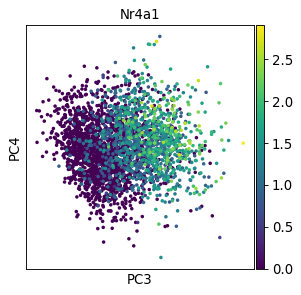

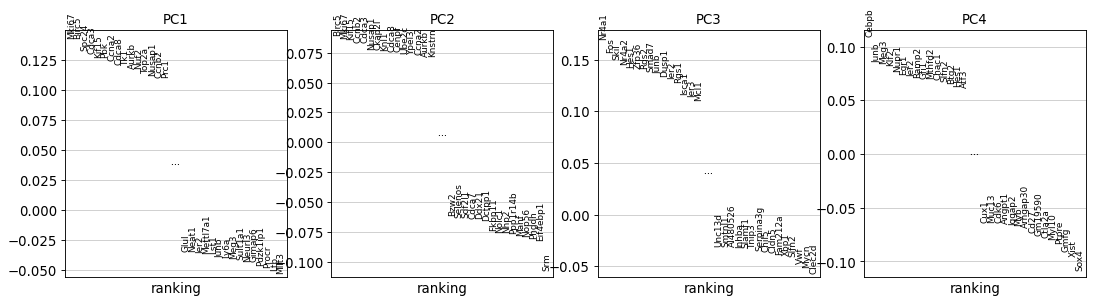

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


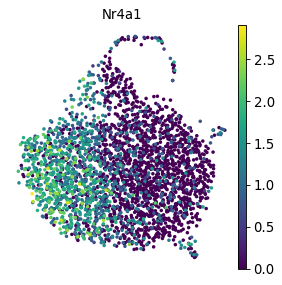

running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


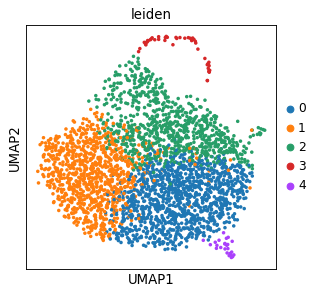

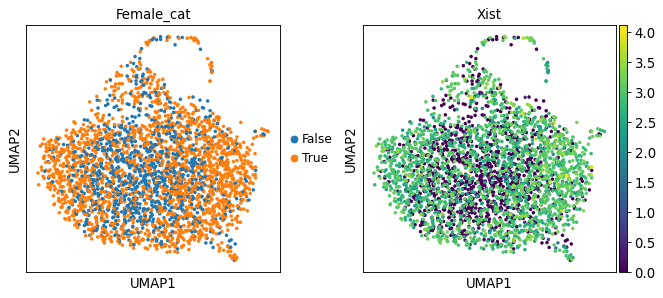

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


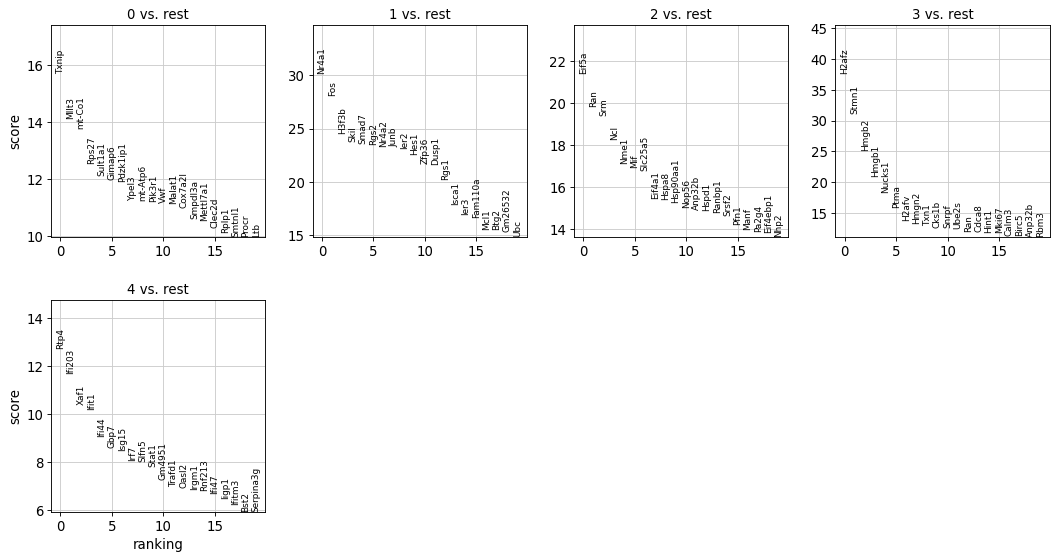

In [4]:
sample = 'GCSF'
adata = preprocess_exp(sample)
adata_GCSF = generic_clustering(adata)

In [5]:
# make ranked gene list document for LTs
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes = adata.raw.shape[1])

# make pd dataframe with all genes and save
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
enrichment_clusters = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj', 'logfoldchanges']})
enrichment_clusters.to_csv('/home/jovyan/work/Z_TRASH/write/clusters_' + sample + '.csv', index=False, header=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


... reading from cache file cache/home-jovyan-work-Z_TRASH-raw_data-A_dmPGE2-outs-filtered_feature_bc_matrix-matrix.h5ad
filtered out 113 cells that have less than 3000 counts
filtered out 11 cells that have more than 20000 counts
Trying to set attribute `.obs` of view, copying.
filtered out 20893 genes that are detected in less than 20 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Total number of cells: 650
Number of cells after min count filter: 537
Number of cells after max count filter: 526
Number of cells after MT filter: 476
Number of cells after gene filter: 476
Total number of genes: 31053
Number of genes after cell filter: 10160


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
... storing 'Female_str' as categorical
... storing 'feature_types' as categorical


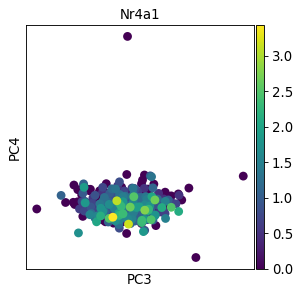

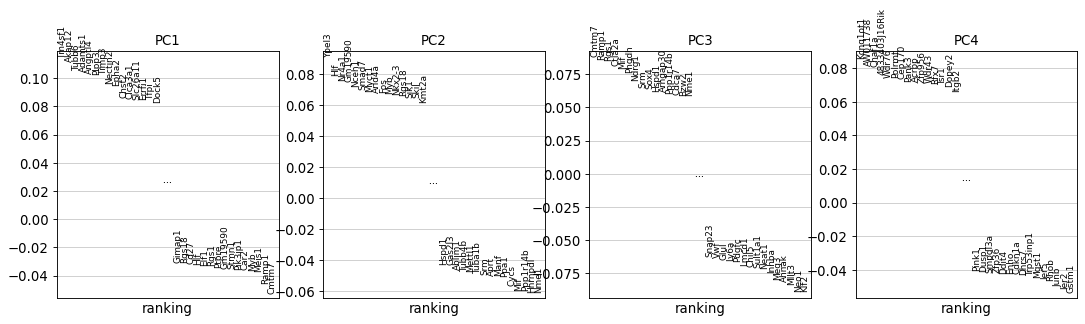

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


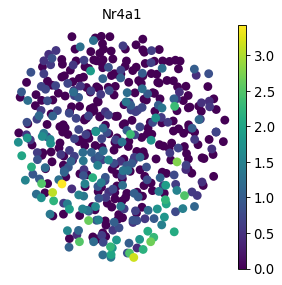

running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


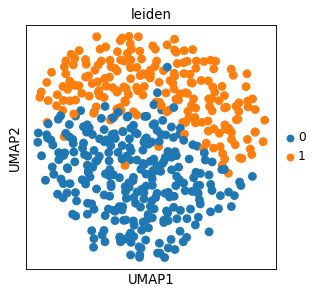

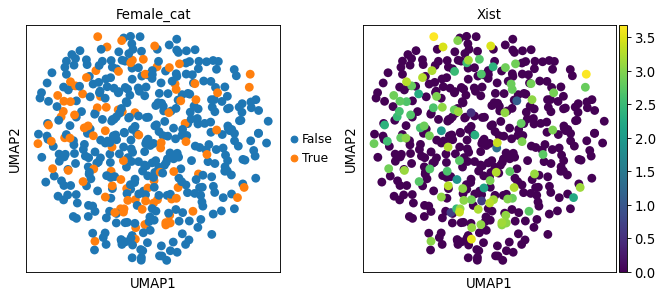

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


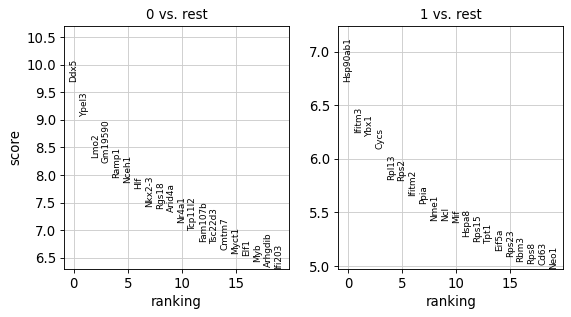

In [6]:
sample = 'dmPGE2'
adata = preprocess_exp(sample)
adata_GCSF = generic_clustering(adata)

In [7]:
# make ranked gene list document for LTs
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes = adata.raw.shape[1])

# make pd dataframe with all genes and save
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
enrichment_clusters = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj', 'logfoldchanges']})
enrichment_clusters.to_csv('/home/jovyan/work/Z_TRASH/write/clusters_' + sample + '.csv', index=False, header=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


... reading from cache file cache/home-jovyan-work-Z_TRASH-raw_data-A_pIC-outs-filtered_feature_bc_matrix-matrix.h5ad
filtered out 93 cells that have less than 3000 counts
filtered out 45 cells that have more than 20000 counts
Trying to set attribute `.obs` of view, copying.
filtered out 20129 genes that are detected in less than 20 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Total number of cells: 932
Number of cells after min count filter: 839
Number of cells after max count filter: 794
Number of cells after MT filter: 748
Number of cells after gene filter: 748
Total number of genes: 31053
Number of genes after cell filter: 10924


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
... storing 'Female_str' as categorical
... storing 'feature_types' as categorical


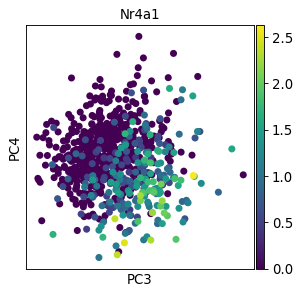

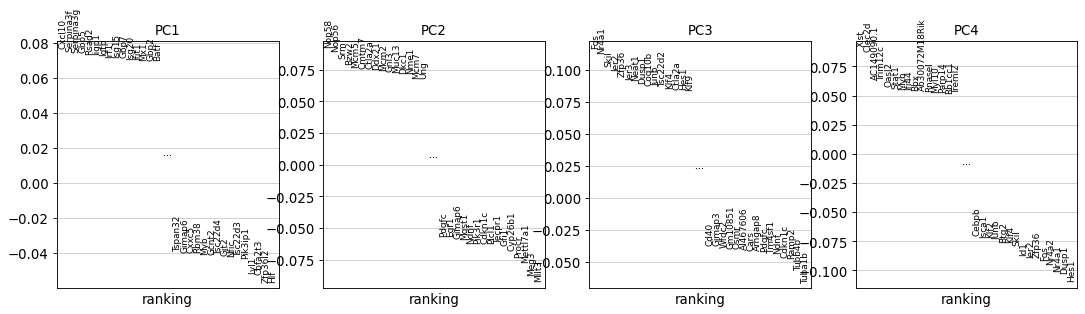

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


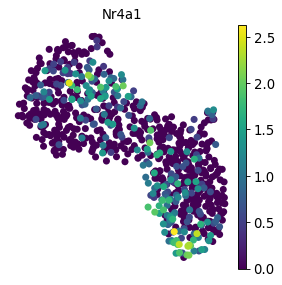

running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


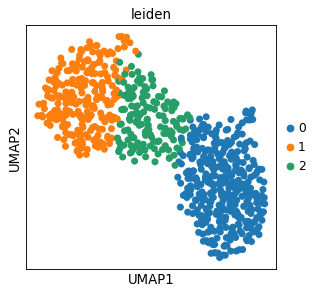

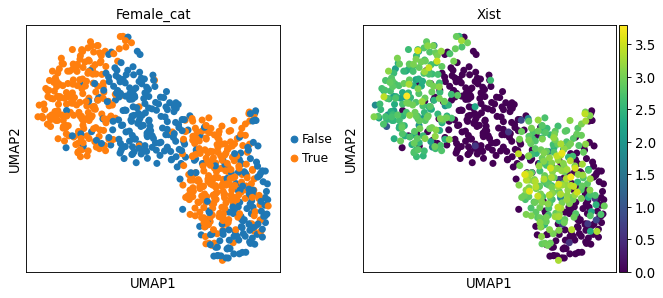

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


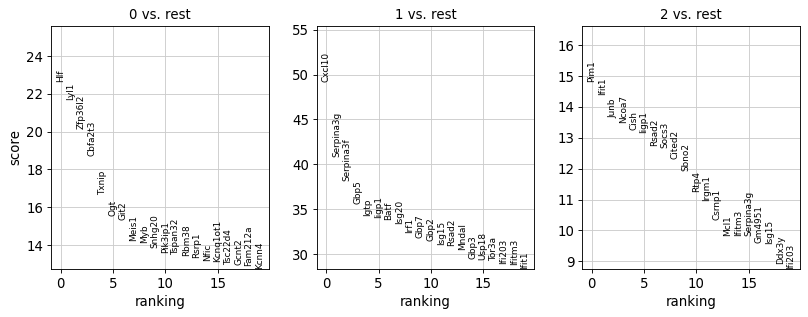

In [8]:
sample = 'pIC'
adata = preprocess_exp(sample)
adata_GCSF = generic_clustering(adata)

In [9]:
# make ranked gene list document for LTs
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes = adata.raw.shape[1])

# make pd dataframe with all genes and save
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
enrichment_clusters = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj', 'logfoldchanges']})
enrichment_clusters.to_csv('/home/jovyan/work/Z_TRASH/write/clusters_' + sample + '.csv', index=False, header=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


... reading from cache file cache/home-jovyan-work-Z_TRASH-raw_data-A_ct-outs-filtered_feature_bc_matrix-matrix.h5ad
filtered out 303 cells that have less than 3000 counts
filtered out 82 cells that have more than 20000 counts


Total number of cells: 6111
Number of cells after min count filter: 5808
Number of cells after max count filter: 5726
Number of cells after MT filter: 5541


filtered out 20 cells that have less than 1500 genes expressed
Trying to set attribute `.obs` of view, copying.
filtered out 17989 genes that are detected in less than 20 cells


Number of cells after gene filter: 5521
Total number of genes: 31053


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
... storing 'Female_str' as categorical
... storing 'feature_types' as categorical


Number of genes after cell filter: 13064


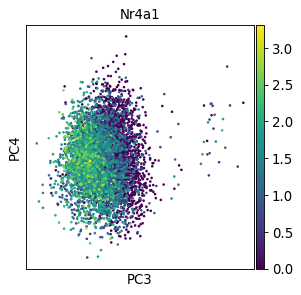

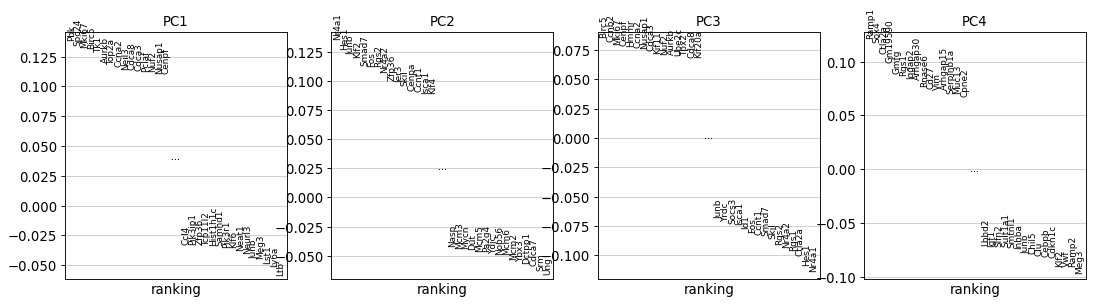

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


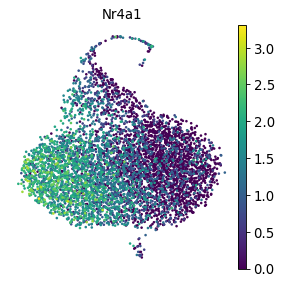

running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


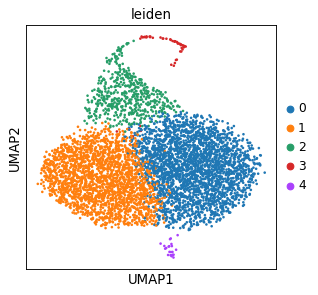

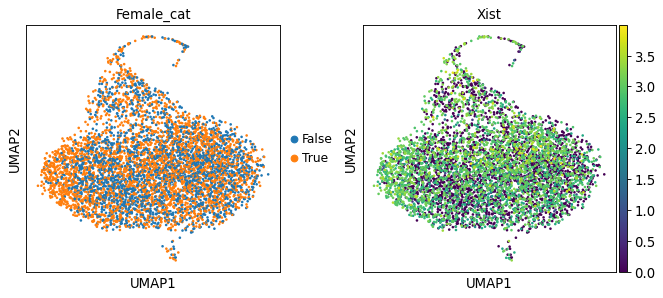

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


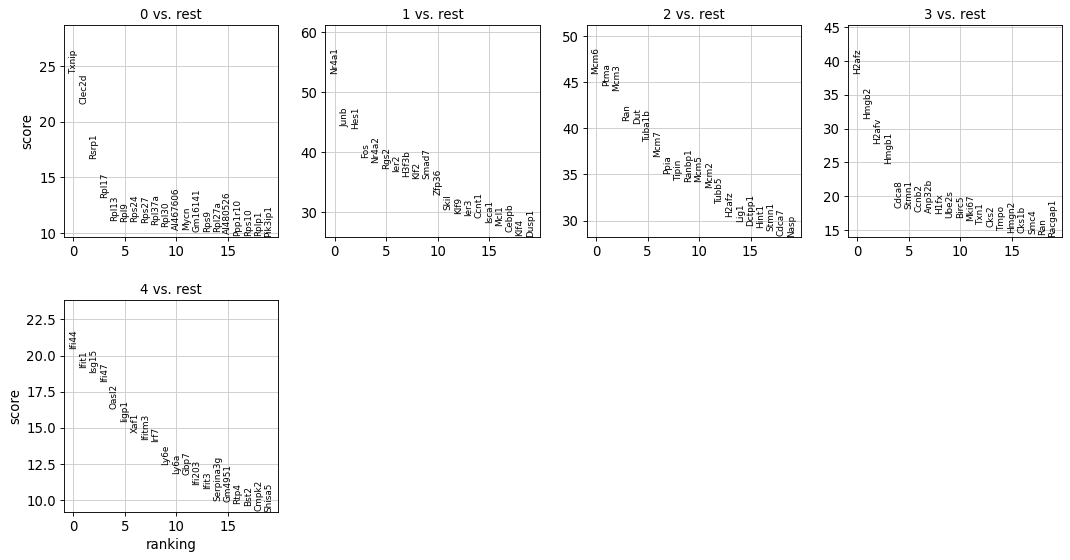

In [10]:
sample = 'ct'
adata = preprocess_exp(sample)
adata_GCSF = generic_clustering(adata)

In [11]:
# make ranked gene list document for LTs
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes = adata.raw.shape[1])

# make pd dataframe with all genes and save
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
enrichment_clusters = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj', 'logfoldchanges']})
enrichment_clusters.to_csv('/home/jovyan/work/Z_TRASH/write/clusters_' + sample + '.csv', index=False, header=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


... reading from cache file cache/home-jovyan-work-Z_TRASH-raw_data-A_indo-outs-filtered_feature_bc_matrix-matrix.h5ad
filtered out 228 cells that have less than 3000 counts
filtered out 28 cells that have more than 20000 counts


Total number of cells: 5940
Number of cells after min count filter: 5712
Number of cells after max count filter: 5684
Number of cells after MT filter: 5640


filtered out 14 cells that have less than 1500 genes expressed
Trying to set attribute `.obs` of view, copying.
filtered out 17997 genes that are detected in less than 20 cells
normalizing by total count per cell


Number of cells after gene filter: 5626
Total number of genes: 31053
Number of genes after cell filter: 13056


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
... storing 'Female_str' as categorical
... storing 'feature_types' as categorical


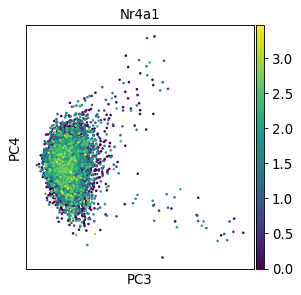

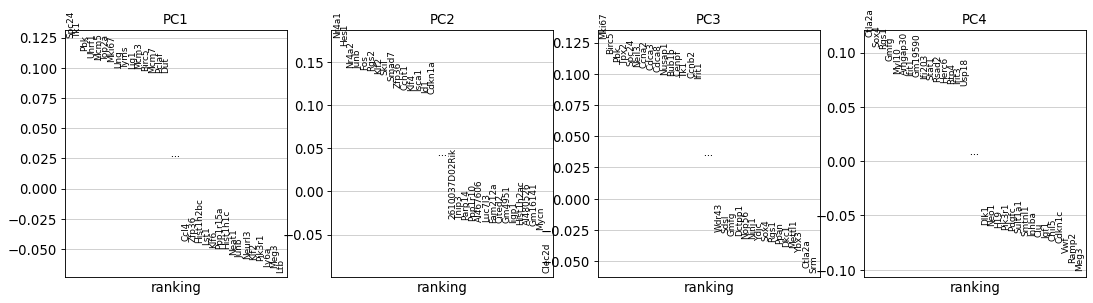

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


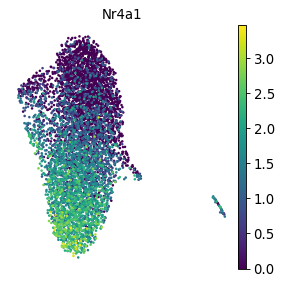

running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


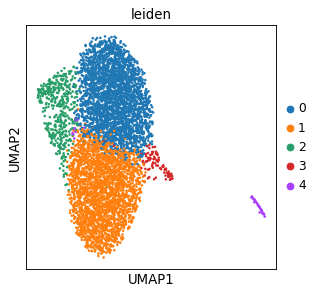

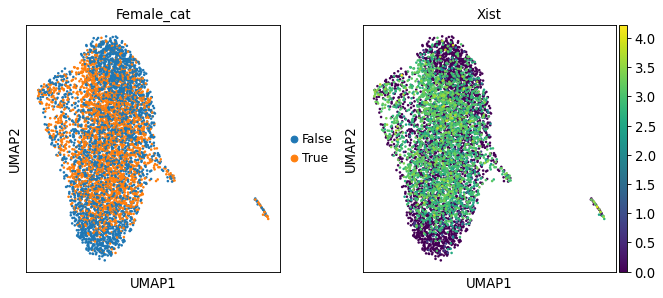

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


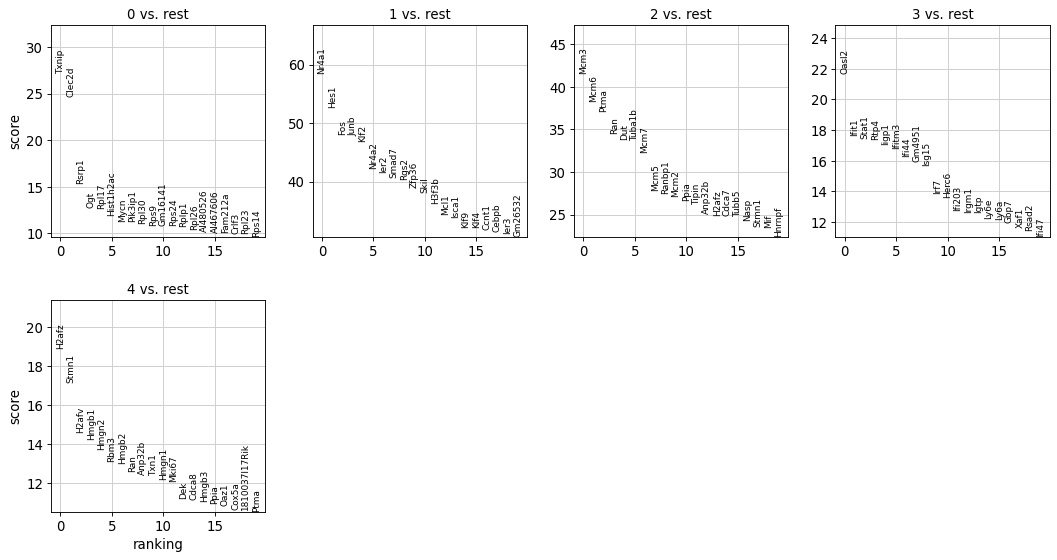

In [12]:
sample = 'indo'
adata = preprocess_exp(sample)
adata_GCSF = generic_clustering(adata)

In [13]:
# make ranked gene list document for LTs
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes = adata.raw.shape[1])

# make pd dataframe with all genes and save
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
enrichment_clusters = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj', 'logfoldchanges']})
enrichment_clusters.to_csv('/home/jovyan/work/Z_TRASH/write/clusters_' + sample + '.csv', index=False, header=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


In [14]:
sc.logging.print_versions()
pd.show_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.4
-----
PIL                 8.1.2
anyio               NA
argon2              20.1.0
attr                20.3.0
babel               2.9.1
backcall            0.2.0
bottleneck          1.3.2
brotli              NA
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.04.1
dateutil            2.8.1
de